In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import torch
import torch.nn as nn
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from torch.utils.data import DataLoader, Dataset
from torchmetrics import F1Score
from tqdm import tqdm 
tqdm.pandas()

In [2]:
max_words = 2000
max_len = 20
num_classes = 1
epochs = 5
batch_size = 512
print_batch_n = 100

In [3]:
df = pd.read_csv('data/train.csv')
df_train, df_test = train_test_split(df, random_state=41, test_size=0.25)
df_train.shape, df_test.shape

((23971, 3), (7991, 3))

In [4]:
df_train.head()

,id,label,tweet
1646,1647,0,stepmom is one of the saddest films ever ð¢ ...
16078,16079,0,i'm the worst person ð¥ð«ðâ¹ð« ð...
4192,4193,0,today is my first day at my job :) can't wait ...
8023,8024,0,no more m&amp;m's in mcflurries? say what?! #m...
15976,15977,0,i'm so and #grateful now that - #affirmations


In [5]:
df_train['label'].value_counts()

0    22314
1     1657
Name: label, dtype: int64

In [6]:
df_test.tail()

,id,label,tweet
22729,22730,0,when you realize that the high school is close...
6922,6923,0,"@user wow fox news, his parents are afghan ori..."
21930,21931,0,i'm weak ðððð 3-2
10329,10330,0,today i left my taco bell to go to a different...
8997,8998,0,@user take time to do what makes your soul ha...


In [7]:
df_test['label'].value_counts()

0    7406
1     585
Name: label, dtype: int64

In [8]:
sw = set(get_stop_words('en'))
puncts = set(punctuation)

In [9]:
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = ''.join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [10]:
df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_test['tweet'] = df_test['tweet'].progress_apply(preprocess_text)

100%|████████████████████████████████████████████████████████████████████████████| 7991/7991 [00:01<00:00, 6698.22it/s]


In [11]:
train_corpus = ' '.join(df_train['tweet'])
train_corpus = train_corpus.lower()

In [12]:
tokens = word_tokenize(train_corpus)
tokens[:5]

['stepmom', 'one', 'saddest', 'films', 'ever']

In [13]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [14]:
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words - 1)]  # вычитание 1 для padding
len(tokens_filtered_top)

1999

In [15]:
tokens_filtered_top[:10]

['user', 'love', 'day', 'happy', 'amp', 'just', 'will', 'u', 'time', 'im']

In [16]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
vocabulary

{'user': 1,
 'love': 2,
 'day': 3,
 'happy': 4,
 'amp': 5,
 'just': 6,
 'will': 7,
 'u': 8,
 'time': 9,
 'im': 10,
 'like': 11,
 'life': 12,
 'today': 13,
 'new': 14,
 'now': 15,
 'positive': 16,
 'thankful': 17,
 'get': 18,
 'people': 19,
 'bihday': 20,
 'good': 21,
 'one': 22,
 'cant': 23,
 'can': 24,
 'see': 25,
 'dont': 26,
 'smile': 27,
 'fathers': 28,
 'want': 29,
 'take': 30,
 'work': 31,
 'go': 32,
 'healthy': 33,
 'got': 34,
 'make': 35,
 'weekend': 36,
 'fun': 37,
 '2': 38,
 'need': 39,
 'beautiful': 40,
 'us': 41,
 'way': 42,
 'summer': 43,
 'best': 44,
 'great': 45,
 'bull': 46,
 'friday': 47,
 'friends': 48,
 'first': 49,
 'going': 50,
 'family': 51,
 'wait': 52,
 'really': 53,
 'days': 54,
 'music': 55,
 'morning': 56,
 'tomorrow': 57,
 'cute': 58,
 'back': 59,
 'know': 60,
 'never': 61,
 'world': 62,
 'sad': 63,
 'week': 64,
 'fathersday': 65,
 'think': 66,
 'orlando': 67,
 'feel': 68,
 'blog': 69,
 'happiness': 70,
 'home': 71,
 'affirmation': 72,
 'trump': 73,
 'model'

In [17]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen - len(result))
    return result[-maxlen:] + padding

In [18]:
%%time
x_train = np.asarray([text_to_sequence(tweet, max_len) for tweet in df_train['tweet']])
x_test = np.asarray([text_to_sequence(tweet, max_len) for tweet in df_test['tweet']])

CPU times: total: 2.39 s
Wall time: 2.4 s


In [19]:
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)        
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)
        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = torch.sigmoid(output)
        return output

In [20]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [21]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DataWrapper(x_test, df_test['label'].values)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [22]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 20])
torch.Size([512])
tensor(0)


In [23]:
model = Net(vocab_size=max_words)

In [24]:
print(model)
print('Parameters:', sum([param.nelement() for param in model.parameters()]))

Net(
  (embedding): Embedding(2000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)
Parameters: 346497


In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [26]:
model.train()
f1 = F1Score()
th = 0.5

train_loss_history = []
test_loss_history = []

for epoch in tqdm(range(epochs)):  
    running_items, running_right = 0.0, 0.0
    f1_res = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчёт ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        
        # подсчёт метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        f1_res += f1(outputs, labels)
        
    # выводим статистику о процессе обучения
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'F1: {f1_res / len(train_loader):.4f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    
    running_items, running_right = 0.0, 0.0
    f1_res = 0.0
    train_loss_history.append(loss)
    
    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    test_f1_res = 0
    
    for j, data in enumerate(test_loader):
        test_labels = data[1]
        test_outputs = model(data[0])
        
        # подсчёт ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        
        # подсчёт метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
        test_f1_res += f1(test_outputs, test_labels)
    
    test_loss_history.append(test_loss.item())
    
    print(f'Test loss: {test_loss:.3f}. ' \
          f'Test F1: {test_f1_res / len(test_loader):.4f}. ' \
          f'Test acc: {test_running_right / test_running_total:.3f}')
    
    model.train()
        
print('Training is finished!')

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Epoch [1/5]. Step [47/47]. Loss: 0.207. F1: 0.0017. Acc: 0.921. 

 20%|████████████████▊                                                                   | 1/5 [00:02<00:11,  2.81s/it]

Test loss: 0.223. Test F1: 0.0000. Test acc: 0.927
Epoch [2/5]. Step [47/47]. Loss: 0.167. F1: 0.1247. Acc: 0.935. 

 40%|█████████████████████████████████▌                                                  | 2/5 [00:05<00:08,  2.83s/it]

Test loss: 0.073. Test F1: 0.1786. Test acc: 0.946
Epoch [3/5]. Step [47/47]. Loss: 0.135. F1: 0.6871. Acc: 0.962. 

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:08<00:05,  2.80s/it]

Test loss: 0.100. Test F1: 0.2213. Test acc: 0.943
Epoch [4/5]. Step [47/47]. Loss: 0.087. F1: 0.7980. Acc: 0.974. 

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:11<00:02,  2.81s/it]

Test loss: 0.005. Test F1: 0.2334. Test acc: 0.946
Epoch [5/5]. Step [47/47]. Loss: 0.040. F1: 0.8666. Acc: 0.982. 

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.80s/it]

Test loss: 0.000. Test F1: 0.1961. Test acc: 0.947
Training is finished!


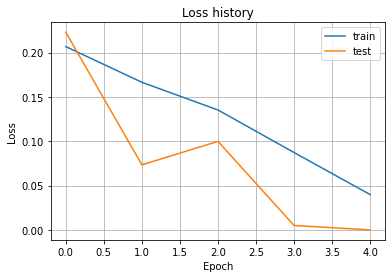

In [27]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();